In [1]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sodapy import Socrata
from geopandas import gpd
import pysal as ps
import numpy as np
import folium

This file is to generate the autocorrelation for the map. 

Below is pulling the data fro mthe api and doing data cleaning

In [2]:
client = Socrata("data.cityofchicago.org", 'EjrjYzG6YAkBx7bPBzME8jD4c')
results = client.get("w3hi-cfa4",limit = 500000)

complaints = pd.DataFrame.from_records(results)

In [3]:
split = complaints['beat'].str.split('|').apply(pd.Series, 1).stack()
split.index = split.index.droplevel(-1)
split.name = 'beat'
del complaints['beat']
split = split.apply(lambda x: x.strip())
complaints = complaints.join(split, how ="right")
complaints['complaint_date'] =  pd.to_datetime(complaints['complaint_date'], format='%Y%m%dT%H:%M:%S.%f')
complaints['complaint_year'] = complaints.complaint_date.dt.year

In [4]:
beats_gpd = gpd.read_file('policebeats.shp')
beats_gpd['beat_num'] = pd.to_numeric(beats_gpd['beat_num'])

Below I turn the categorical variable of race into a dummy so I can aggregate the number of complaints by race per beat

In [5]:
race = complaints[['beat','race_of_complainant']].dropna()
race_long = pd.get_dummies(race, columns = ['race_of_complainant']) 
race_long.rename(columns={'race_of_complainant_African American / Black':'Black', 
                          'race_of_complainant_American Indian or Alaskan Native':'AmerIndianAlaskan',
                         'race_of_complainant_Asian or Pacific Islander':'Apia',
                          'race_of_complainant_Hispanic':'Hispanic',
                          'race_of_complainant_Unknown':'Unknown',
                          'race_of_complainant_White':'White'
                         }, inplace=True)
race_long =race_long.groupby(['beat']).agg({'Black':[sum],'AmerIndianAlaskan':[sum],
                                'Apia':[sum],'Hispanic':[sum],
                                'Unknown':[sum],'White':[sum]})
race_long.columns = race_long.columns.droplevel(1)
race_long = race_long.reset_index()
race_long['beat'] = pd.to_numeric(race_long['beat'])

Below I turn the categorical variable of complaint type into a dummy so I can aggregate the number of complaints by type per beat

In [6]:
type = complaints[['beat','current_category']].dropna()
type_long = pd.get_dummies(type, columns=['current_category'])
type_long = type_long.rename(columns={'current_category_Bias':'bias',
                         'current_category_Civil Suits':'civilsuits',
                         'current_category_Coercion':'coercion',
                         'current_category_Death or Injury In Custody':'deathinjuryincustody',
                         'current_category_Domestic Violence':'domesticviolence',
                         'current_category_Excessive Force':'excessforce',
                         'current_category_Firearm Discharge - Hits':'firearmhit',
                         'current_category_Firearm Discharge - No Hits':'firearmnohit',
                         'current_category_Firearm Discharge at Animal':'firearmanimal',
                         'current_category_Legal Violation':'legalviol',
                         'current_category_Miscellaneous':'misc',
                         'current_category_Motor Vehicle Related Death':'motordeath',
                         'current_category_OC Discharge':'ocdischarge',
                         'current_category_Operational Violation':'operationviolation',
                         'current_category_Search or Seizure':'searchseizure',
                         'current_category_Taser Discharge':'taserdischarge',
                         'current_category_Taser Notification':'tasernotif',
                         'current_category_Unlawful Denial of Counsel':'denialcounsel',
                         'current_category_Unnecessary Display of Weapon':'unnecessarydispweapon',
                         'current_category_Verbal Abuse':'verbalabuse'})
type_long = type_long.groupby(['beat']).agg({'bias':[sum],'civilsuits':[sum],
                                'coercion':[sum],'deathinjuryincustody':[sum],
                                'domesticviolence':[sum],'excessforce':[sum],
                               'firearmhit':[sum],'firearmnohit':[sum],
                                'firearmanimal':[sum],'legalviol':[sum],
                                'misc':[sum],'motordeath':[sum],
                               'ocdischarge':[sum],'operationviolation':[sum],
                                'searchseizure':[sum],'taserdischarge':[sum],
                                'tasernotif':[sum],'denialcounsel':[sum],
                               'unnecessarydispweapon':[sum],'verbalabuse':[sum]})
type_long.columns = type_long.columns.droplevel(1)
type_long = type_long.reset_index()
type_long['beat'] = pd.to_numeric(type_long['beat'])

In [7]:
total_beat =beats_gpd.merge(type_long, right_on='beat',left_on='beat_num', how ='left')
total_beat = total_beat.merge(race_long,right_on='beat',left_on='beat_num', how ='left')
#pd.merge(type_long,race_long,how='inner',on='beat',left_index=True)

Here I've created some autocorrelation clusters based on certain variables

C:\Users\patri\Anaconda3\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\patri\Anaconda3\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\patri\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


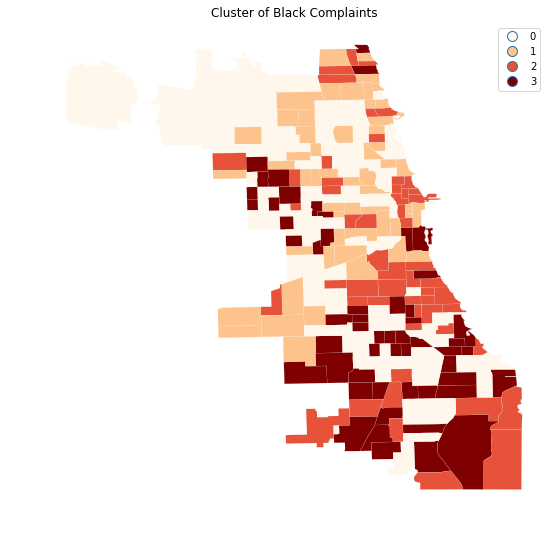

In [8]:
black5 = ps.Quantiles(total_beat.Black, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=black5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Black Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


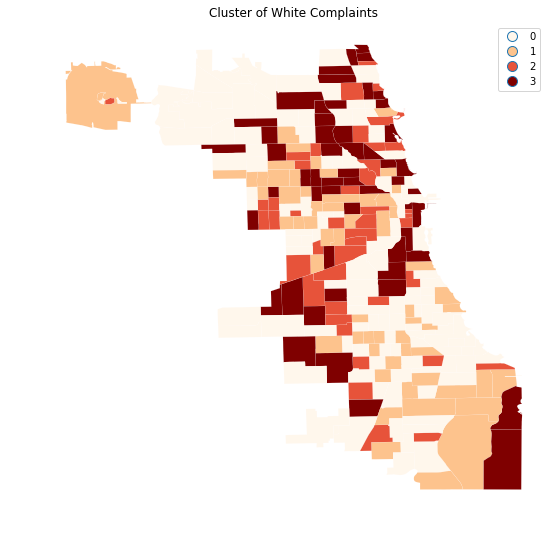

In [151]:
white5 = ps.Quantiles(total_beat.White, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=white5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of White Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


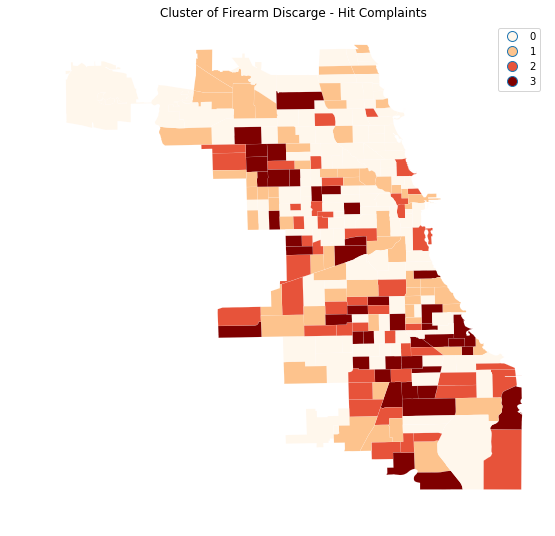

In [152]:
firearmhit5 = ps.Quantiles(total_beat.firearmhit, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=firearmhit5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Firearm Discarge - Hit Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


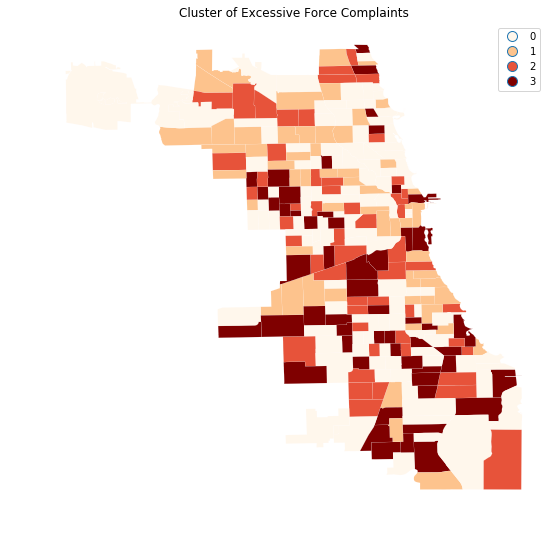

In [153]:
excess5 = ps.Quantiles(total_beat.excessforce, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=excess5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Excessive Force Complaints")
plt.show()

In [9]:
data = total_beat
data = data.fillna(0)

In [10]:
W = ps.weights.Queen.from_dataframe(data)
W.transform = 'r'

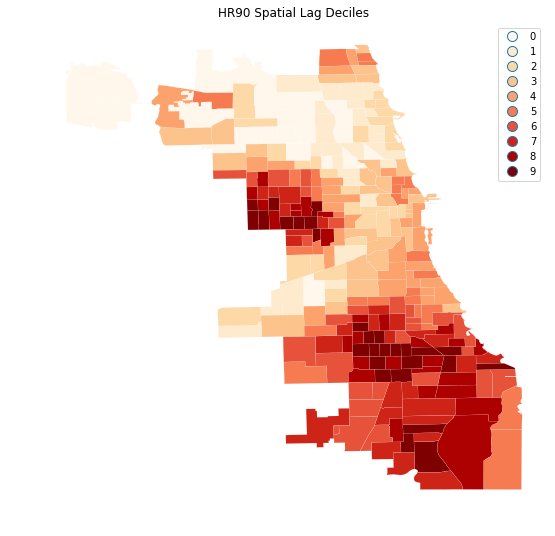

In [11]:
HR90Lag = ps.lag_spatial(W, data.Black)
HR90LagQ10 = ps.Quantiles(HR90Lag, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")

plt.show()

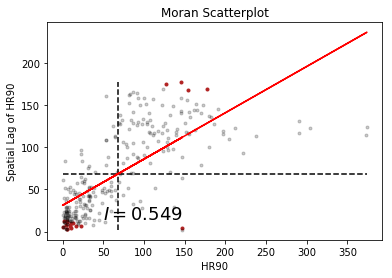

In [12]:
I_HR90 = ps.Moran(data.Black.values, W)
LMo_HR90 = ps.Moran_Local(data.Black.values, W)
LMo_HR90 = ps.Moran_Local(data.Black.values, W, permutations=9999)
Lag_HR90 = ps.lag_spatial(W, data.Black.values)
HR90 = data.Black.values
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

b,a = np.polyfit(HR90, Lag_HR90, 1)

plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

plt.show()

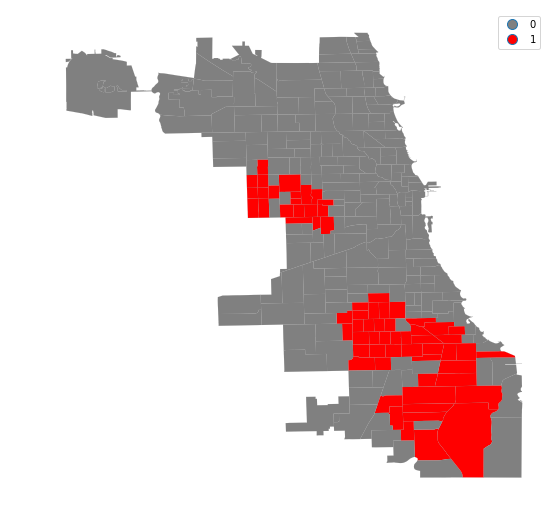

In [13]:
sig = LMo_HR90.p_sim < 0.05
sig.sum()
hotspots = LMo_HR90.q==1 * sig
hotspots.sum()
coldspots = LMo_HR90.q==3 * sig
coldspots.sum()
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

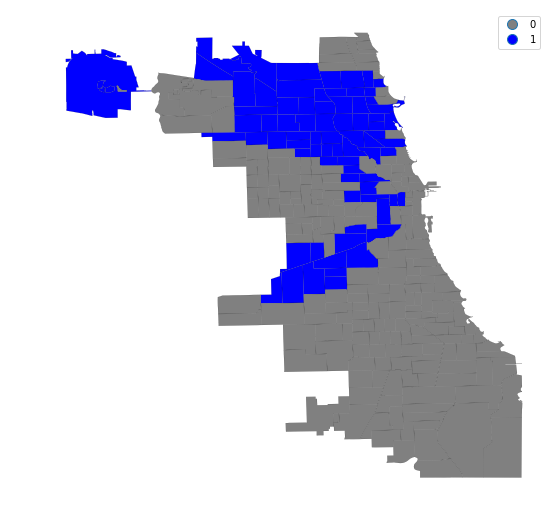

In [15]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

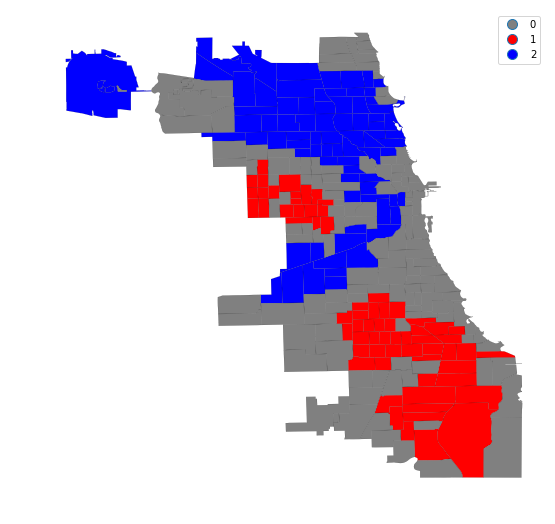

In [15]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

In [96]:
hc_df = pd.DataFrame(hotcold)

blackmap = beats_gpd.join(hc_df)
blackmap.rename(columns={0: 'type'}, inplace=True)

style = pd.DataFrame({'type': [0,1,2], 'style': [
    {'fillColor': '#e3dfd6', 'weight': .25, 'color': 'black'},
    {'fillColor': '#dd3232', 'fillOpacity' : .85, 'weight': .25, 'color': 'black'},
    {'fillColor': '#a2d0cf', 'fillOpacity' : .85, 'weight': .25, 'color': 'black'},
    ]})
blackmap = blackmap.merge(style)

In [121]:
cook_coords = [41.849452, -87.835731]
width, height = 400, 500

my_map = folium.Map(location = cook_coords, zoom_start = 10, 
                    tiles = 'cartodbpositron', width=width, height=height)

folium.GeoJson(blackmap.to_crs({'init': 'epsg:4326'}).to_json()).add_to(my_map)

my_map.save('map.html')

In [130]:
for index, row in blackmap.to_crs({'init': 'epsg:4326'}).to_json().iterrows():
    c = folium.GeoJson(row, name = (row['beat_num']),overlay=False, 
                       style_function = lambda feature: {'fillColor': '#ffaf00','color': 'blue', 'weight': 1.5,'dashArray': '5, 5'},
                       highlight_function = lambda feature: {'fillColor': '#ffaf00','color': 'green', 'weight': 3,'dashArray': '5, 5'})
    c.add_child(folium.Popup(rrow['beat_num']))
    c.add_to(my_map)

my_map.save('map.html')

AttributeError: 'str' object has no attribute 'iterrows'